#Understanding the Objective
###Predicting job placement success and the time it takes for fellows to receive job offers


# Import Dataset


In [148]:
from google.colab import files

In [149]:
uploaded = files.upload()

Saving Data_Pathrise.xlsx to Data_Pathrise (7).xlsx


 # Import Libraries

In [150]:
import pandas as pd

# Read the Data

In [151]:
df = pd.read_excel('Data_Pathrise.xlsx')

# Data Understanding

In [152]:
# Display the first few rows of the dataframe to understand its structure
df.head()

,id,pathrise_status,primary_track,cohort_tag,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race
0,1,Active,SWE,OCT19A,NaN,0,Unemployed,Bachelor's Degree,3-5 months,Hearing back on my applications,3-4 years,Canada Citizen,2.0,900,Male,Non-Hispanic White or Euro-American
1,2,Active,PSO,JAN20A,NaN,0,Unemployed,"Some College, No Degree",3-5 months,Getting past final round interviews,1-2 years,Citizen,6.0,0,Male,Non-Hispanic White or Euro-American
2,3,Closed Lost,Design,AUG19B,0.0,0,Employed Part-Time,Master's Degree,Less than one month,Figuring out which jobs to apply for,Less than one year,Citizen,0.0,0,Male,East Asian or Asian American
3,4,Closed Lost,PSO,AUG19B,0.0,0,Contractor,Bachelor's Degree,Less than one month,Getting past final round interviews,Less than one year,Citizen,5.0,25,Male,Decline to Self Identify
4,5,Placed,SWE,AUG19A,89.0,1,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American


#Clean Data

In [153]:
# Drop 'cohort_tag' column
df.drop('cohort_tag', axis=1, inplace=True)

In [154]:
# Check for missing values
missing_values = df.isnull().sum()

In [155]:
# Calculate the percentage of missing values for each column
missing_percentage = (missing_values / len(df)) * 100

missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

missing_data.sort_values(by='Percentage', ascending=False)

,Missing Values,Percentage
program_duration_days,616,24.213836
gender,492,19.339623
work_authorization_status,284,11.163522
employment_status,229,9.001572
professional_experience,222,8.726415
number_of_interviews,218,8.569182
length_of_job_search,74,2.908805
highest_level_of_education,58,2.279874
biggest_challenge_in_search,24,0.943396
race,18,0.707547


In [156]:
from sklearn.impute import SimpleImputer

# Impute numerical columns with the median
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
numerical_imputer = SimpleImputer(strategy='median')
df[numerical_columns] = numerical_imputer.fit_transform(df[numerical_columns])

# Impute categorical columns with 'Unknown'
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

# Check if there are any missing values left
missing_values_after = df.isnull().sum().sum()

missing_values_after


0

In [157]:
from sklearn.preprocessing import OneHotEncoder

# Selecting categorical variables for one-hot encoding
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply one-hot encoding
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid dummy variable trap
encoded_columns = encoder.fit_transform(df[categorical_columns])

# Create a DataFrame with the encoded columns
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_columns))

# Drop original categorical columns from df
df.drop(categorical_columns, axis=1, inplace=True)

# Concatenate the original DataFrame (without categorical columns) with the new encoded columns
preprocessed_df = pd.concat([df, encoded_df], axis=1)

# Display the shape of the dataframe to confirm the changes
preprocessed_df.shape, preprocessed_df.head()


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((2544, 71),
     id  program_duration_days  placed  number_of_interviews  \
 0  1.0                  112.0     0.0                   2.0   
 1  2.0                  112.0     0.0                   6.0   
 2  3.0                    0.0     0.0                   0.0   
 3  4.0                    0.0     0.0                   5.0   
 4  5.0                   89.0     1.0                  10.0   
 
    number_of_applications  pathrise_status_Break  pathrise_status_Closed Lost  \
 0                   900.0                    0.0                          0.0   
 1                     0.0                    0.0                          0.0   
 2                     0.0                    0.0                          1.0   
 3                    25.0                    0.0                          1.0   
 4                   100.0                    0.0                          0.0   
 
    pathrise_status_Deferred  pathrise_status_MIA  pathrise_status_Placed  ...  \
 0                       

#Exploratory Data Analysis (EDA)

<ipython-input-158-7708c5e2b691>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['Others', 'SWE'])


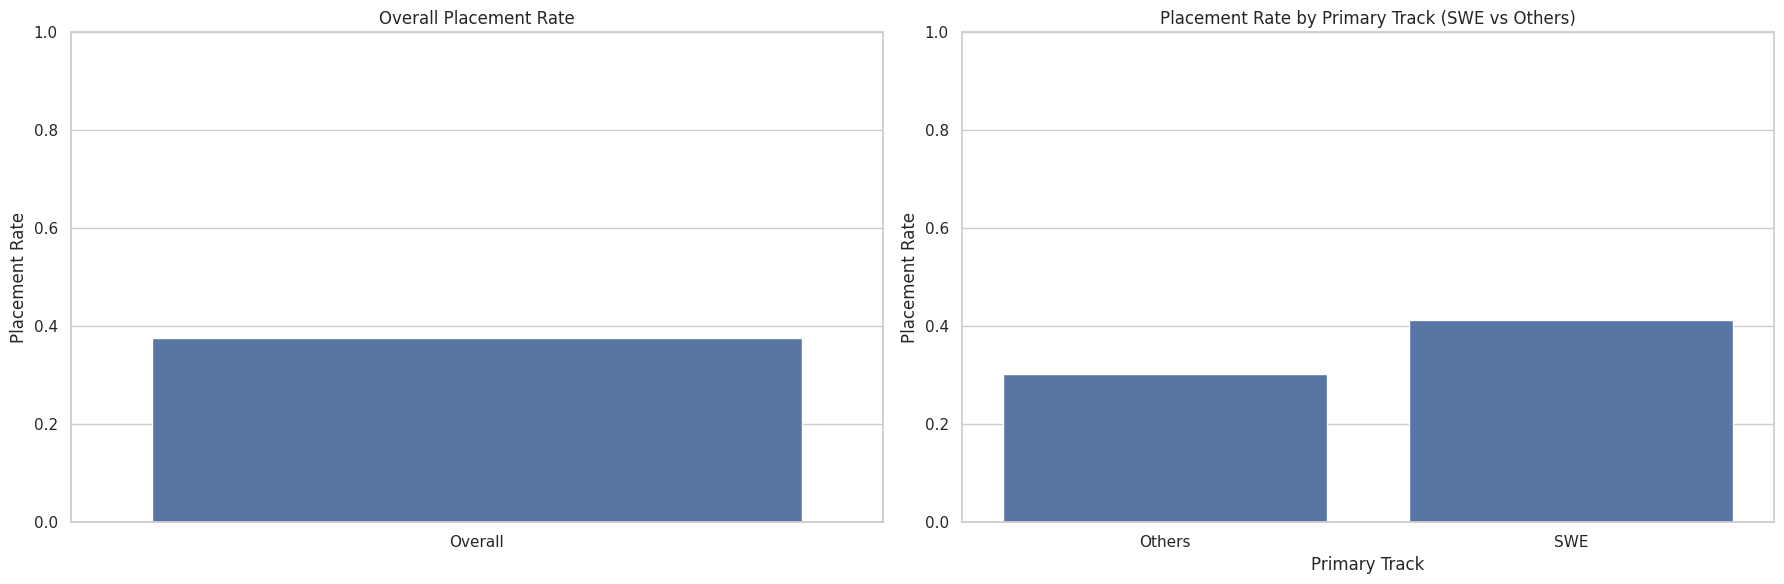

0.3757861635220126

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Placement Rate Overall
placement_rate_overall = preprocessed_df['placed'].mean()

# Placement Rate by Primary Track
placement_rate_by_track = preprocessed_df.groupby('primary_track_SWE')['placed'].mean().reset_index()

# Placement Rate by Education Level
# Extracting column names related to education for grouping
education_levels = [col for col in preprocessed_df.columns if 'highest_level_of_education' in col]
education_data = preprocessed_df[education_levels + ['placed']]
education_data_long = pd.melt(education_data, id_vars=['placed'], value_vars=education_levels)
education_data_long = education_data_long[education_data_long['value'] == 1]
placement_rate_by_education = education_data_long.groupby('variable')['placed'].mean().reset_index()

# Visualizing the Placement Rate Overall and by Primary Track
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Overall Placement Rate
sns.barplot(x=['Overall'], y=[placement_rate_overall], ax=ax[0])
ax[0].set_title('Overall Placement Rate')
ax[0].set_ylabel('Placement Rate')
ax[0].set_ylim(0, 1)

# Placement Rate by Primary Track
sns.barplot(x='primary_track_SWE', y='placed', data=placement_rate_by_track, ax=ax[1])
ax[1].set_title('Placement Rate by Primary Track (SWE vs Others)')
ax[1].set_ylabel('Placement Rate')
ax[1].set_xlabel('Primary Track')
ax[1].set_xticklabels(['Others', 'SWE'])
ax[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Displaying the overall placement rate for reference
placement_rate_overall


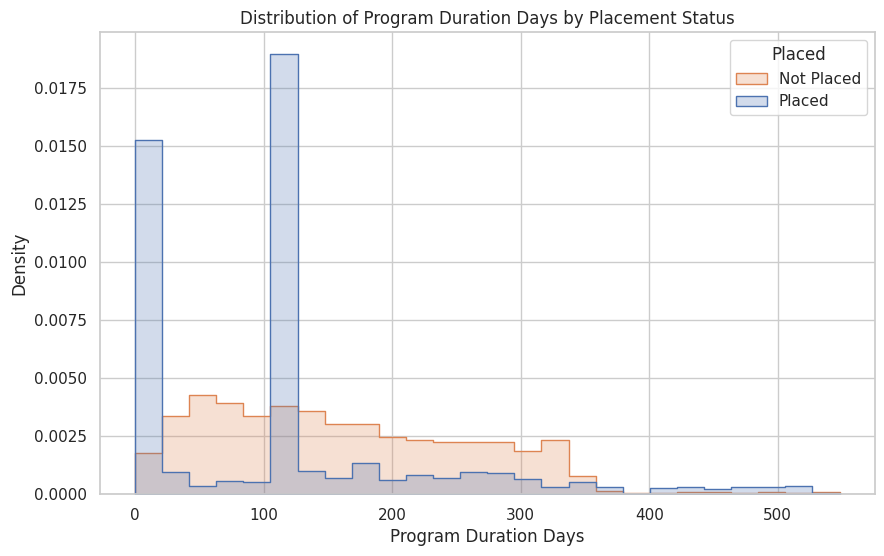

In [159]:
# Distribution of Program Duration for Placed vs Not Placed
plt.figure(figsize=(10, 6))
sns.histplot(data=preprocessed_df, x='program_duration_days', hue='placed', element='step', stat='density', common_norm=False)
plt.title('Distribution of Program Duration Days by Placement Status')
plt.xlabel('Program Duration Days')
plt.ylabel('Density')
plt.legend(title='Placed', labels=['Not Placed', 'Placed'])
plt.show()


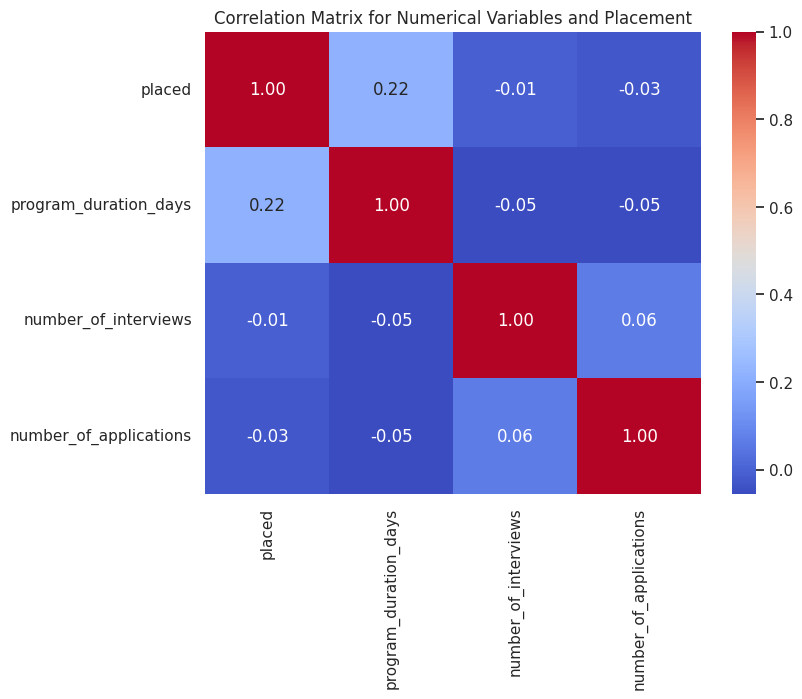

In [160]:
# Correlation matrix focusing on 'placed' and numerical variables
correlation_matrix = preprocessed_df[['placed', 'program_duration_days', 'number_of_interviews', 'number_of_applications']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Numerical Variables and Placement')
plt.show()


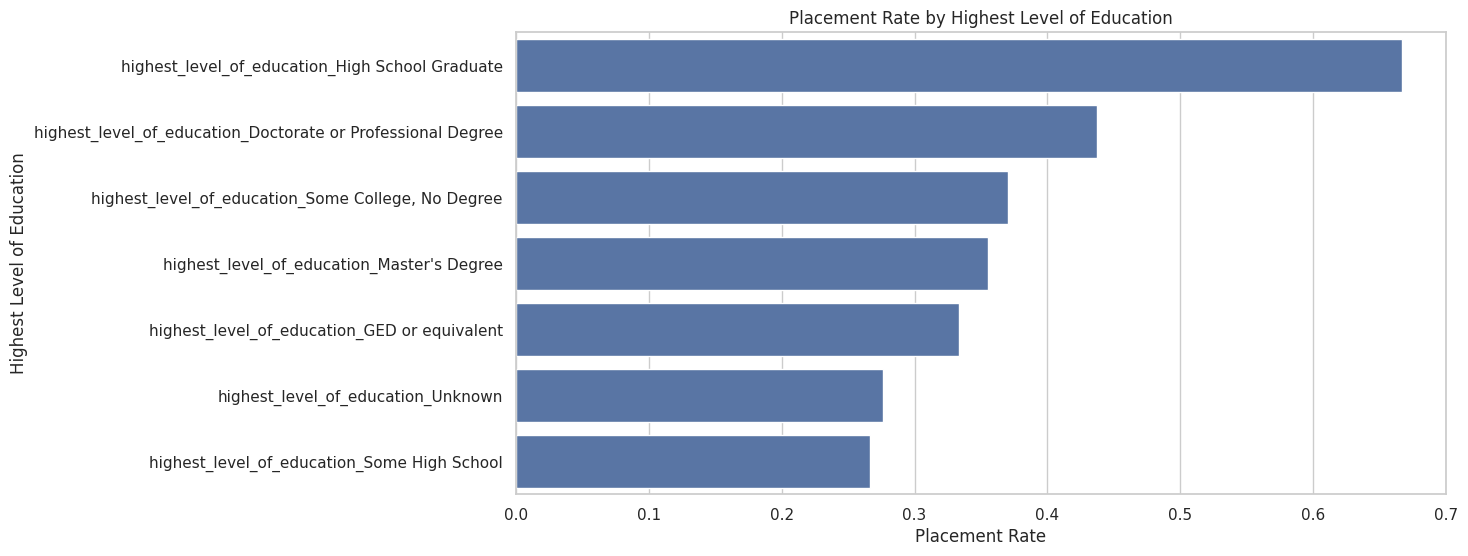

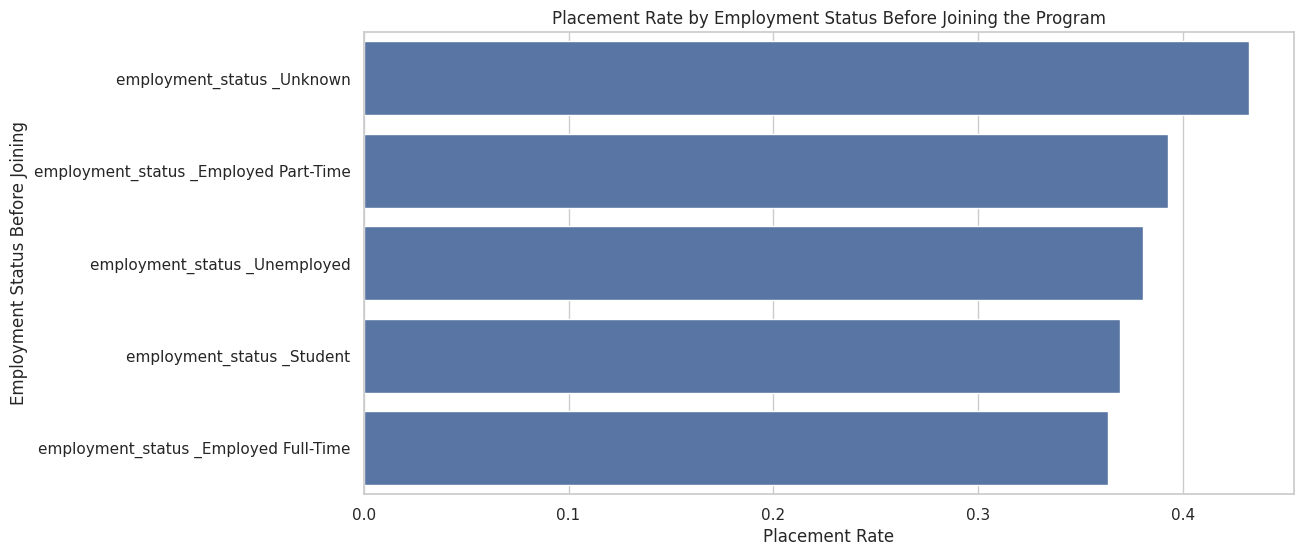

In [161]:
# For simplicity and visualization purposes, let's focus on a couple of significant categorical variables
# We already prepared placement rate by education level, now let's visualize it

# Sorting the placement rate by education for better visualization
placement_rate_by_education_sorted = placement_rate_by_education.sort_values(by='placed', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='placed', y='variable', data=placement_rate_by_education_sorted)
plt.title('Placement Rate by Highest Level of Education')
plt.xlabel('Placement Rate')
plt.ylabel('Highest Level of Education')
plt.show()

# Exploring the impact of employment status before joining the program on placement outcomes
employment_status_columns = [col for col in preprocessed_df.columns if 'employment_status' in col]
employment_status_data = preprocessed_df[employment_status_columns + ['placed']]
employment_status_data_long = pd.melt(employment_status_data, id_vars=['placed'], value_vars=employment_status_columns)
employment_status_data_long = employment_status_data_long[employment_status_data_long['value'] == 1]
placement_rate_by_employment_status = employment_status_data_long.groupby('variable')['placed'].mean().reset_index()

# Sorting the placement rate by employment status for better visualization
placement_rate_by_employment_status_sorted = placement_rate_by_employment_status.sort_values(by='placed', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='placed', y='variable', data=placement_rate_by_employment_status_sorted)
plt.title('Placement Rate by Employment Status Before Joining the Program')
plt.xlabel('Placement Rate')
plt.ylabel('Employment Status Before Joining')
plt.show()
